$$
\newcommand{\fudm}[2]{\frac{\mathrm{D} #1}{\mathrm{D} #2}}
\newcommand{\pad}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ppad}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\ppadd}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}
\newcommand{\nnabla}{\nabla^2}
\newcommand{\eps}{\epsilon}
\newcommand{\vdetail}[1]{\vb{#1}=\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\vb}[1]{\mathbf{#1}}
\newcommand{\va}[1]{\vec{#1}}
\newcommand{\tb}[1]{\underline{\underline{\mathbf{#1}}}}
\newcommand{\fud}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}
$$

# Wave propagation in an inhomogeneous media

The wave equation in an inhomogeneous medium reads as

\begin{equation}
\frac{1}{\rho c^2}\ppad{p}{t}-\nabla \cdot \left(\frac{1}{\rho}(\nabla p)\right)=0
\end{equation}

\begin{equation}
\ppad{p}{t}=\rho c^2 \left( (\nabla \frac{1}{\rho}) \nabla p + \frac{1}{\rho} \nabla^2 p \right)
\end{equation}

Let us write this in two dimensions (x,y):

\begin{equation}
\ppad{p}{t}=c^2 \left[ -\frac{1}{\rho}\left(\pad{\rho}{x}\pad{p}{x}+\pad{\rho}{y}\pad{p}{y}\right) + \left( \ppad{p}{x}+\ppad{p}{y} \right) \right]
\end{equation}

We can write finite differences as:

\begin{equation}
p_{i,j}^{n+1}=2p_{i,j}^n-p_{i,j}^{n-1}+\\
\frac{(\Delta t)^2}{(\Delta x)^2} \left[ c_{i,j}^2 \left( p_{i-1,j}+p_{i+1,j}+p_{i,j-1}+p_{i,j+1}-4p_{i,j} \right)-
\frac{1}{4\rho_{i,j}} \left( \left(\rho_{i+1,j}-\rho_{i-1,j}\right)\left(p_{i+1,j}-p_{i-1,j}\right) + 
\left(\rho_{i,j+1}-\rho_{i,j-1}\right)\left(p_{i,j+1}-p_{i,j-1}\right)\right)
\right]
\end{equation}


## Open Boundaries 

A simple method to implement an open boundary is to approximate the boundary with a plane wave radiating out of the volume, i.e. the boundary points fulfill the outgoing plane wave equation

\begin{equation}
\vb{n}\cdot\nabla p + \frac{1}{c}\pad{p}{t}=0\quad ,
\end{equation}

where $\vb{n}$ is the normal vector. 

We can write this boundary condition in finite differences as

$$...$$

In [1]:
%matplotlib notebook 
import math as m
import numpy #array operations
import matplotlib.pyplot as plt #plotting
from ipywidgets import widgets #for the widgets
#from ipykernel.client import display
from IPython import display #for continous display
#from PIL import Image #to export images

nimg=0

def savemyimage(visual):
    global nimg
    visual = (visual +2.)/4.
    #result = Image.fromarray((visual * 255).astype(numpy.uint8))
    #result.save('out{:03d}.bmp'.format(nimg))
    nimg=nimg+1

def plotwave(u,time,px,py,pp,pt,d):
    plt.figure(1)
    plt.clf()
    #plot the pressue field
    plt.subplot2grid((4,4),(0,0), colspan = 4, rowspan = 3)
    plt.imshow(u, origin='upper', extent=[0., 2., 0., 2.], vmax=2, vmin=-2) #plot the wave field
    plt.text(0.1,1.8,"time {0:.5f}".format(time)) #annotate the time
    plt.plot(1.,w_probey.value,'o') #position of probe
    #inhomogenities
    phi=numpy.linspace(0.,2.*m.pi,20)
    for i in range(d.size):
        plt.plot(d['radius'][i]*numpy.cos(phi)+d['xpos'][i],2.-d['radius'][i]*numpy.sin(phi)-d['ypos'][i])
    plt.gca().set_xlim([0.,2.])
    plt.gca().set_ylim([0.,2.])
    #plot the pressure at the probe
    plt.subplot2grid((4,4),(3,0), colspan = 4)
    plt.plot(pt,pp) 
    plt.gca().set_ylim([-2,2])
    display.clear_output(wait=True)
    display.display(plt.gcf())
        
def solvewave(b):
    tabs.visible=False
    #computational domain
    nx = ny = 381
    size=2. #size of the domain
    #parameters of the wave
    c = 5. #speed of sound of homogeneous medium 
    l=w_wavelength.value #wavelength
    nu=c/l #frequency
    omega=nu*2.*m.pi #angular frequency
    duration=w_sourceduration.value/nu #duration of source
    #position
    emissionlength=(w_sizeemit.value/100.)*nx
    startx=int(nx/2-emissionlength/2)
    endx=int(nx/2+emissionlength/2)

    #further variables
    dx = size/(nx-1)
    CFL=.3*1./m.sqrt(2.) #CFL number < 1/sqrt(2)
    dt = CFL*dx/c 
    nt=int(w_simduration.value/dt) #number of time steps

    if w_sposition.value=='Top':
        sourcepos=0
    elif w_sposition.value=='Center':
        sourcepos=int(ny/2)
    else:
        sourcepos=ny-1

    #arrays for measuring the pressure at a position
    pt=numpy.arange(nt+1)*dt
    pp=numpy.zeros(nt+1)
    py=int((2.-w_probey.value)*(nx-1)/2.)
    px=int(ny/2)
        
    #every xx times over the total nt timesteps an output should be generated 
    output=map(int,list(numpy.linspace(1,nt,int(nt/50))))

    u  = numpy.zeros((nx,ny)) #pressure at t
    un = numpy.zeros((nx,ny)) #pressure at t-dt
    unn= numpy.zeros((nx,ny)) #pressure at t-2*dt

    #inhomogeneous speed of sound c**2 !
    cc = numpy.ones((nx,ny))
    #inhomogeneous density
    rho = numpy.ones((nx,ny))  
    #build some inhomgeneous medium
    nd=5
    d=numpy.zeros(nd,dtype={'names':['radius','xpos','ypos'],'formats':['f8','f8','f8']})
    #d['radius']=numpy.random.rand(nd)*.2
    d['radius']=numpy.ones(nd)*.1
    d['xpos']=numpy.random.rand(nd)*2.
    d['ypos']=numpy.random.rand(nd)+1.
    xx,yy=numpy.meshgrid(numpy.linspace(0,2.,nx),numpy.linspace(0,2.,nx))
    for i in range(d.size):
        a=numpy.where((xx-d['xpos'][i])**2+(yy-d['ypos'][i])**2<(d['radius'][i]**2))
        cc[a]=5.
        rho[a]=5.
    cc=cc*c*c
    
    phase=(numpy.linspace(startx*dx,endx*dx,endx-startx)-1.)/c*m.tan(w_sangle.value*m.pi/180.)
    phasetot=(phase.max()-phase.min())
    phasemin=phase.min()
    
    plt.figure(1, figsize=(6, 6), dpi=300)
    
    for n in range(nt+1): ##loop across number of time steps

        #here we compute the wave propagation in a inhomogeneous media
        u[1:-1,1:-1]=2.*un[1:-1,1:-1]-unn[1:-1,1:-1]+\
            dt*dt/dx/dx*(cc[1:-1,1:-1]*\
                            (un[:-2,1:-1]+un[2:,1:-1]+un[1:-1,:-2]+un[1:-1,2:]-4.*un[1:-1,1:-1])-\
                             .25*rho[1:-1,1:-1]*((rho[2:,1:-1]-rho[:-2,1:-1])*(un[2:,1:-1]-un[:-2,1:-1])+\
                             (rho[1:-1,2:]-rho[1:-1,:-2])*(un[1:-1,2:]-un[1:-1,:-2])))

        #Impose the boundary conditions                 
        if w_nbc.value=='Open':
            u[0,:] = -dx/dt/(cc[0,:]**.5)*(u[1,:]-un[1,:])+u[1,:]
        else:
            u[0,:] = u[1,:]
        if w_sbc.value=='Open':
            u[-1,:] = -dx/dt/(cc[-1,:]**.5)*(u[-2,:]-un[-2,:])+u[-2,:]
        else:
            u[-1,:] = u[-2,:]
        if w_wbc.value=='Open':
            u[:,0] = -dx/dt/(cc[0,:]**.5)*(u[:,1]-un[:,1])+u[:,1]
        else:
            u[:,0] = u[:,1]
        if w_ebc.value=='Open':
            u[:,-1] = -dx/dt/(cc[:,-1]**.5)*(u[:,-2]-un[:,-2])+u[:,-2]
        else:
            u[:,-1] = u[:,-2]
        
        #pressure source
        if n*dt<(duration+phasetot):
            #generate a source with the correct phase and duration of each phase
            usource=numpy.sin(omega*(n*dt-phase+phasemin))*\
                    ((n*dt+phasemin)>phase)*((n*dt+phasemin)<phase+duration)
            
            if w_sorientation.value=='Horizontal':
                u[sourcepos,startx:endx]=usource
            else:
                u[startx:endx,sourcepos]=usource
            
        #Pressure probe
        pp[n]=u[py,px]
        
        #save values for the time derivative 
        unn=un.copy() #n-1 time steop
        un=u.copy()   #n time step
        
        if (n in output):
            plotwave(u,n*dt,px,py,pp,pt,d)
            if (w_saveplots.value):
                savemyimage(u)
            
    #and plot the last figure    
    plotwave(u,n*dt,px,py,pp,pt,d)
    tabs.visible=True

C:\Users\cdohl\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


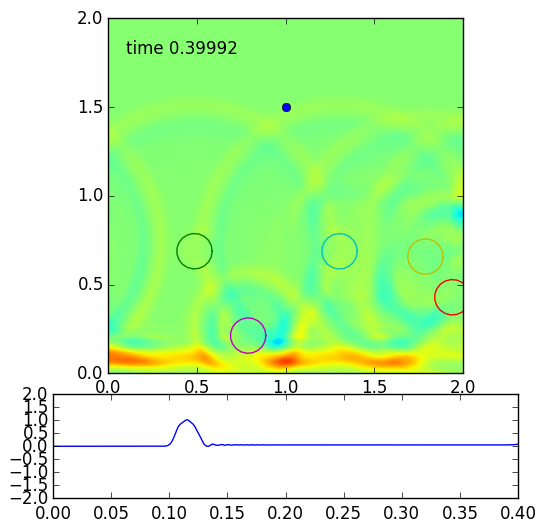

In [2]:
#setup the graphical interface 
w_wavelength=widgets.FloatSlider(description="Wavelength",value=.3,min=0.1,max=1)
w_sizeemit=widgets.FloatSlider(description="Emitter Size in (%)",value=100,min=1,max=100)
w_sourceduration=widgets.FloatSlider(description="Emission Duration in Periods",value=.5,min=0.5,max=10)
w_simduration=widgets.FloatSlider(description="Simulation Duration",value=.4,min=0.1,max=10)
w_saveplots=widgets.Checkbox(description="Save Images",value=False)
w_sposition=widgets.RadioButtons(description="Source Position",options=["Top", "Center", "Bottom"],value="Top",margin=10)
w_sorientation=widgets.RadioButtons(description="Source Orientation",options=["Horizontal", "Vertical"],value="Horizontal",margin=10)
w_sangle=widgets.FloatSlider(description="Angle",value=0,min=-30,max=30)
w_nbc=widgets.RadioButtons(description="North B.C.",options=["Reflective", "Open"],value="Reflective",margin=10)
w_sbc=widgets.RadioButtons(description="South B.C.",options=["Reflective", "Open"],value="Open",margin=10)
w_wbc=widgets.RadioButtons(description="West B.C.",options=["Reflective", "Open"],value="Reflective",margin=10)
w_ebc=widgets.RadioButtons(description="East B.C.",options=["Reflective", "Open"],value="Reflective",margin=10)
w_start=widgets.Button(description="Start Simulation")
w_start.on_click(solvewave)
w_probey=widgets.FloatSlider(description="Probe Position",value=1.5,min=0.,max=2.)
page1=widgets.Box([w_wavelength,w_sizeemit,w_sourceduration,w_simduration])
page2=widgets.HBox([w_sposition,w_sorientation,w_sangle])
page3=widgets.HBox([w_nbc,w_sbc,w_wbc,w_ebc])
page4=widgets.Box([w_saveplots,w_probey])
tabs = widgets.Tab(children=[page1, page2, page3, page4])
tabs.set_title(0, 'Wave')
tabs.set_title(1, 'Source')
tabs.set_title(2, 'Boundary Conditions')
tabs.set_title(3, 'Record')

display.display(tabs)
display.display(w_start)

In [69]:
%load_ext Cython

In [71]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef calcu(np.ndarray[long, ndim=2] u,\
            np.ndarray[long, ndim=2] un, np.ndarray[long, ndim=2] unn,\
            np.ndarray[long, ndim=2] cc, np.ndarray[long, ndim=2] rho, cconst):
    u[1:-1,1:-1]=2.*un[1:-1,1:-1]-unn[1:-1,1:-1]+\
        cconst(cc[1:-1,1:-1]*\
        (un[:-2,1:-1]+un[2:,1:-1]+un[1:-1,:-2]+un[1:-1,2:]-4.*un[1:-1,1:-1])-\
        .25*rho[1:-1,1:-1]*((rho[2:,1:-1]-rho[:-2,1:-1])*(un[2:,1:-1]-un[:-2,1:-1])+\
        (rho[1:-1,2:]-rho[1:-1,:-2])*(un[1:-1,2:]-un[1:-1,:-2])))

    return u